# Анализ бизнес-показателей

## Описание проекта

Требуется провести анализ развлекательного приложения Procrastinate Pro+. Последние несколько месяцев компания терпит убытки. Задача -  разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Цель иследования**<br>
Выявить причины убытков бизнеса в последние несколько месяцев.

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

**Описание данных**<br>

**Структура visits_info_short.csv:**
 * User Id — уникальный идентификатор пользователя,
 * Region — страна пользователя,
 * Device — тип устройства пользователя,
 * Channel — идентификатор источника перехода,
 * Session Start — дата и время начала сессии,
 * Session End — дата и время окончания сессии.<br>
 
**Структура orders_info_short.csv:**
 * User Id — уникальный идентификатор пользователя,
 * Event Dt — дата и время покупки,
 * Revenue — сумма заказа.<br>
 
**Структура costs_info_short.csv:**
 * dt — дата проведения рекламной кампании,
 * Channel — идентификатор рекламного источника,
 * costs — расходы на эту кампанию.

#### Обзор данных

In [67]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math
import warnings
import time
from datetime import datetime
from datetime import date, timedelta as td
warnings.filterwarnings('ignore')

In [68]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visit = pd.read_csv('visits_info_short.csv')
    order = pd.read_csv('orders_info_short.csv')
    cost = pd.read_csv('costs_info_short.csv')

**Предобработка данных для visit**

In [69]:
visit.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [70]:
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Поменяем название столбцов,приведем их к нижнему регистру

In [71]:
visit.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

Преобразование данных о времени

In [72]:
visit['session_start'] = pd.to_datetime(visit['session_start'])
visit['session_end'] = pd.to_datetime(visit['session_end'])

Наличие пропусков 

In [73]:
visit.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

Наличие дубликатов

In [74]:
visit.duplicated().sum()

0

**Предобработка данных для order**

In [75]:
order.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

Поменяем название столбцов,приведем их к нижнему регистру

In [76]:
order.columns = ['user_id', 'event_dt', 'revenue']

In [77]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Наличие пропусков

In [78]:
order.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

Наличие дубликатов

In [79]:
order.duplicated().sum()

0

Преобразование данных о времени

In [80]:
order['event_dt'] = pd.to_datetime(order['event_dt'])

**Предобработка данных для cost**

In [81]:
cost.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Поменяем название столбцов,приведем их к нижнему регистру

In [82]:
cost.columns = ['dt', 'channel', 'costs']

Преобразование данных о времени

In [83]:
cost['dt'] = pd.to_datetime(cost['dt']).dt.date

In [84]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Наличие пропусков

In [85]:
cost.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

Наличие дублткатов

In [86]:
cost.duplicated().sum()

0

**Общий вывод:**
* Исправлены нарушения стиля, столбцы приведены к snake case
* Пропуски и дубликаты в таблицах отсутствуют
* Заменили формат времени в соответствующих столбцах <br>
<br>Данные готовы для анализа.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функции для вычисления значений метрик

Функция для создания пользовательских профилей get_profiles

In [87]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для расчета удержания get_retention

In [88]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Функция для расчета конверсии get_conversion

In [89]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Функция для расчета LTV, ROI

In [90]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функции для визуализации этих метрик**

In [91]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Функция для визуализации удержания

In [92]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Функция для визуализации конверсии

In [93]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации LTV и ROI

In [94]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 20))
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Создание профилей пользователей

In [95]:
event=None #выведем из расчета недостающий файл с регистрацией событий
profiles = get_profiles(visit, order, event, cost)
print('количество профилей:', len(profiles))
display(profiles.head())

количество профилей: 150008


user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

Найдем минимальную и максимальную дату привлечения пользователей:

In [96]:
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max() 

In [97]:
print('Минимальная дата привлечения пользователей', min_analysis_date)
print('Максимальная дата привлечения пользователей', observation_date)

Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


Начальная дата привлечения пользователей - 1 мая 2019 года. Конечная дата привлечения пользователей - 27 октября 2019 года. Все корректно, с ТЗ согласуется (цитата из ТЗ: "Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года")

#### Анализ пользователей в разрезе стран.  Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [98]:
visit.head()

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

Сгруппируем профили пользователей по региону и рассчитаем количество уникальных пользователей и количество платящих в каждом из них:

In [99]:
profiles_region = (
    profiles.groupby('region')['user_id', 'payer']
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)
profiles_region['%_region'] = round(profiles_region['user_id'] / profiles_region['user_id'].sum() *100, 1)
profiles_region['%_payers'] = round(profiles_region['payer'] / profiles_region['user_id'] *100, 1)
profiles_region.sort_values(by='payer', ascending=False)

region  user_id  payer  %_region  %_payers
3  United States   100002   6902      66.7       6.9
2             UK    17575    700      11.7       4.0
0         France    17450    663      11.6       3.8
1        Germany    14981    616      10.0       4.1

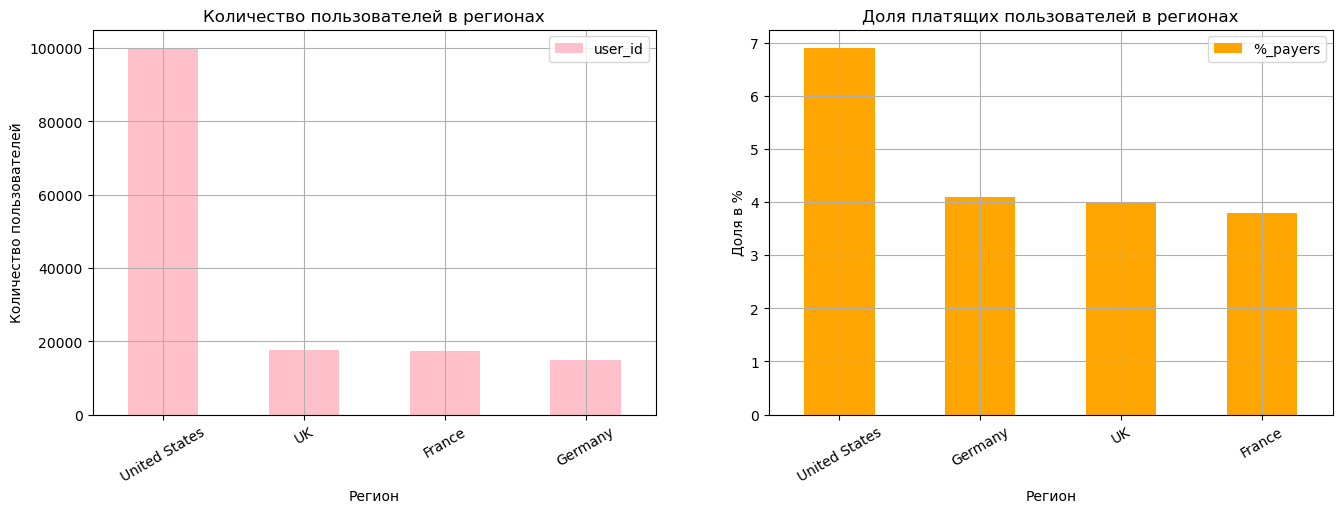

In [100]:
plt.figure(figsize=(16, 5))

number_of_users = plt.subplot(1, 2, 1)
profiles_region.sort_values(by='user_id', ascending=False).plot.bar(
x='region', y=['user_id'], grid=True,
title='Количество пользователей в регионах', 
rot=30, color='pink', ax=number_of_users).set(xlabel='Регион', ylabel='Количество пользователей')

share = plt.subplot(1, 2, 2)
profiles_region.sort_values(by='%_payers', ascending=False).plot.bar(
x='region', y=['%_payers'], grid=True,
title='Доля платящих пользователей в регионах',
rot=30, color='orange',ax=share).set(xlabel='Регион', ylabel='Доля в %');

Больше всего пользователей из США (United States), оставшаяся доля приходится почти поравну на Великобритании(UK), Франции(France) и Германии(Germany). Доля платящих пользователей так же в большей степени приходится на США.

#### Анализ устройств, которыми пользуются клиенты, а так же какие устройства предпочитают платящие пользователи.

Сгруппируем профили по устройствам и подсчитаем общее количество пользователей и количество перешедших в категорию платящих:

In [101]:
profiles_device = (
    profiles.groupby('device')['user_id', 'payer']
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)
profiles_device['%_payers'] = round(profiles_device['payer'] / profiles_device['user_id'] * 100, 1)
profiles_device.sort_values(by='payer', ascending=False)

device  user_id  payer  %_payers
3   iPhone    54479   3382       6.2
0  Android    35032   2050       5.9
1      Mac    30042   1912       6.4
2       PC    30455   1537       5.0

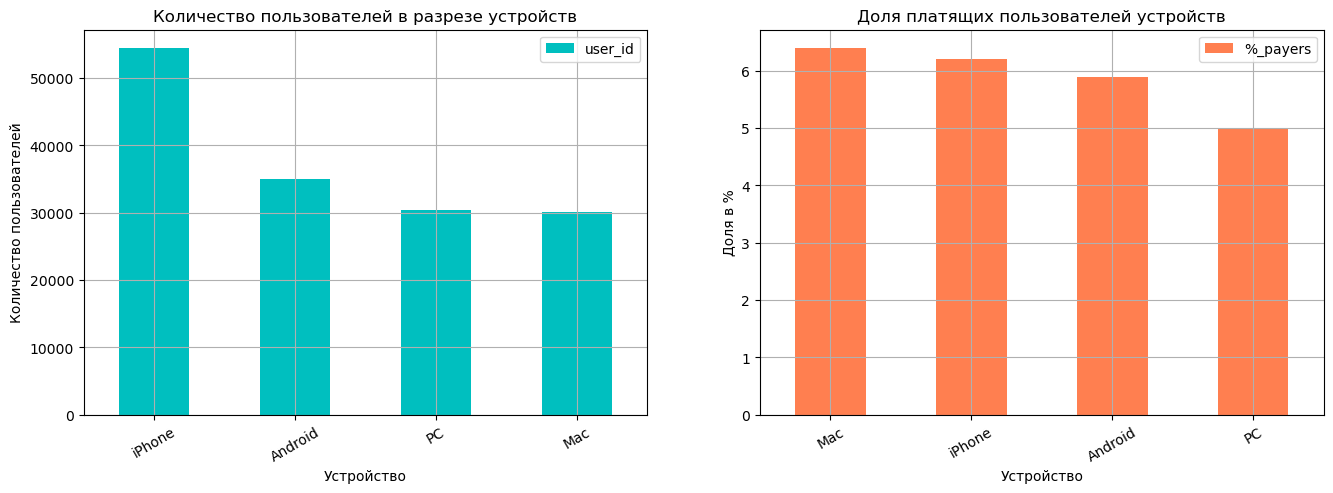

In [102]:
plt.figure(figsize=(16, 5))

number_of_users = plt.subplot(1, 2, 1)
profiles_device.sort_values(by='user_id', ascending=False).plot.bar(
x='device', y=['user_id'], grid=True,
title='Количество пользователей в разрезе устройств', 
rot=30, color='c', ax=number_of_users).set(xlabel='Устройство', ylabel='Количество пользователей')

share = plt.subplot(1, 2, 2)
profiles_device.sort_values(by='%_payers', ascending=False).plot.bar(
x='device', y=['%_payers'], grid=True,
title='Доля платящих пользователей устройств',
rot=30,color='coral', ax=share).set(xlabel='Устройство', ylabel='Доля в %');


Больше всего пользователей приложения это владельцы iPhone. Доля платящих пользователей приходится в большей степени на владельцев Mac и iPhone. 

####  Анализ рекламных источников привлечения. Определение каналов, из которых пришло больше всего платящих пользователей.

Cгруппируем профили по рекламному источнику, найдем общее количество и количество платящих пользователей каждого канала:

In [103]:
profiles_channel = (
    profiles.groupby('channel')['user_id', 'payer']
    .agg({'user_id': 'count', 'payer':'sum'}).reset_index()
)
# % пользователей каждого канала 
profiles_channel['%_users'] = round(profiles_channel['user_id'] / profiles_channel['user_id'].sum() * 100, 1)
# % платящих внутри канала
profiles_channel['%_payers'] = round(profiles_channel['payer'] / profiles_channel['user_id'] * 100, 1)

profiles_channel.sort_values(by='user_id', ascending=False)

channel  user_id  payer  %_users  %_payers
10             organic    56439   1160     37.6       2.1
1             FaceBoom    29144   3557     19.4      12.2
6               TipTop    19561   1878     13.0       9.6
4   OppleCreativeMedia     8605    233      5.7       2.7
2              LeapBob     8553    262      5.7       3.1
7       WahooNetBanner     8553    453      5.7       5.3
5       RocketSuperAds     4448    352      3.0       7.9
3         MediaTornado     4364    156      2.9       3.6
8              YRabbit     4312    165      2.9       3.8
0           AdNonSense     3880    440      2.6      11.3
9       lambdaMediaAds     2149    225      1.4      10.5

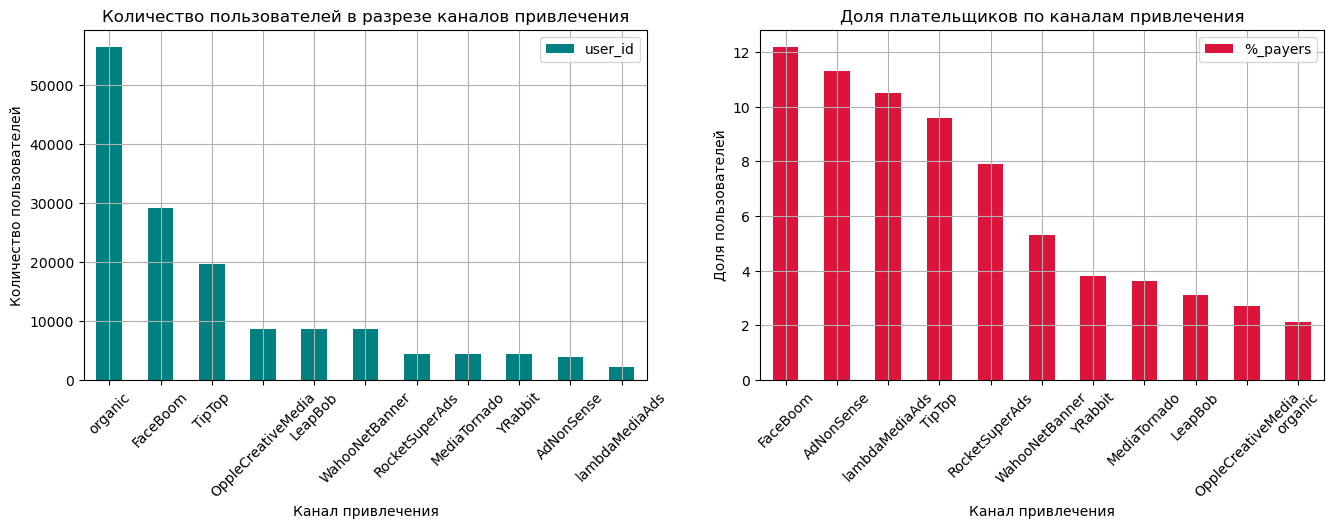

In [104]:
plt.figure(figsize=(16, 10))

number_of_users = plt.subplot(2, 2, 1)
profiles_channel.sort_values(by='user_id', ascending=False).plot.bar(
x='channel', y=['user_id'],grid=True,
title='Количество пользователей в разрезе каналов привлечения', 
rot=45, color='teal', ax=number_of_users).set(xlabel='Канал привлечения', ylabel='Количество пользователей')

share = plt.subplot(2, 2, 2)
profiles_channel.sort_values(by='%_payers', ascending=False).plot.bar(
x='channel', y=['%_payers'], grid=True,
title='Доля плательщиков по каналам привлечения',
rot=45, color='crimson', ax=share).set(xlabel='Канал привлечения', ylabel='Доля пользователей');

Самый крупный платный источник FaceBoom	и AdNonSense. Большее количество пользователей, находят приложение самостоятельно из  источника organic.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Расходы на маркетинг

**Посчитаем общую сумму расходов на маркетинг.**

In [105]:
print('Общая сумма расходов на рекламу:',int(cost['costs'].sum()))

Общая сумма расходов на рекламу: 105497


**Распределение суммы расходов на рекламу по источникам, то есть сколько денег потратили на каждый источник:**

In [106]:
profiles_costs = cost.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs',ascending=False)
profiles_costs['%'] =round((profiles_costs['costs'] / profiles_costs['costs'].sum())*100, 2)
profiles_costs

costs      %
channel                            
TipTop              54751.30  51.90
FaceBoom            32445.60  30.75
WahooNetBanner       5151.00   4.88
AdNonSense           3911.25   3.71
OppleCreativeMedia   2151.25   2.04
RocketSuperAds       1833.00   1.74
LeapBob              1797.60   1.70
lambdaMediaAds       1557.60   1.48
MediaTornado          954.48   0.90
YRabbit               944.22   0.90

Добавим в датафрейм costs столбцы месяца и недели

In [107]:
cost['month'] = cost['dt'].astype('datetime64[M]')
cost['week'] = cost['dt'].astype('datetime64[W]')

In [108]:
cost.head()

dt   channel  costs      month       week
0  2019-05-01  FaceBoom  113.3 2019-05-01 2019-04-25
1  2019-05-02  FaceBoom   78.1 2019-05-01 2019-05-02
2  2019-05-03  FaceBoom   85.8 2019-05-01 2019-05-02
3  2019-05-04  FaceBoom  136.4 2019-05-01 2019-05-02
4  2019-05-05  FaceBoom  122.1 2019-05-01 2019-05-02

Посчитаем расходы помесячно

In [109]:
cost.groupby('month').agg({'costs': 'sum'})

costs
month                
2019-05-01   9978.570
2019-06-01  15090.045
2019-07-01  16447.060
2019-08-01  20657.870
2019-09-01  22441.340
2019-10-01  20882.415

Визуализируем изменения во времени 

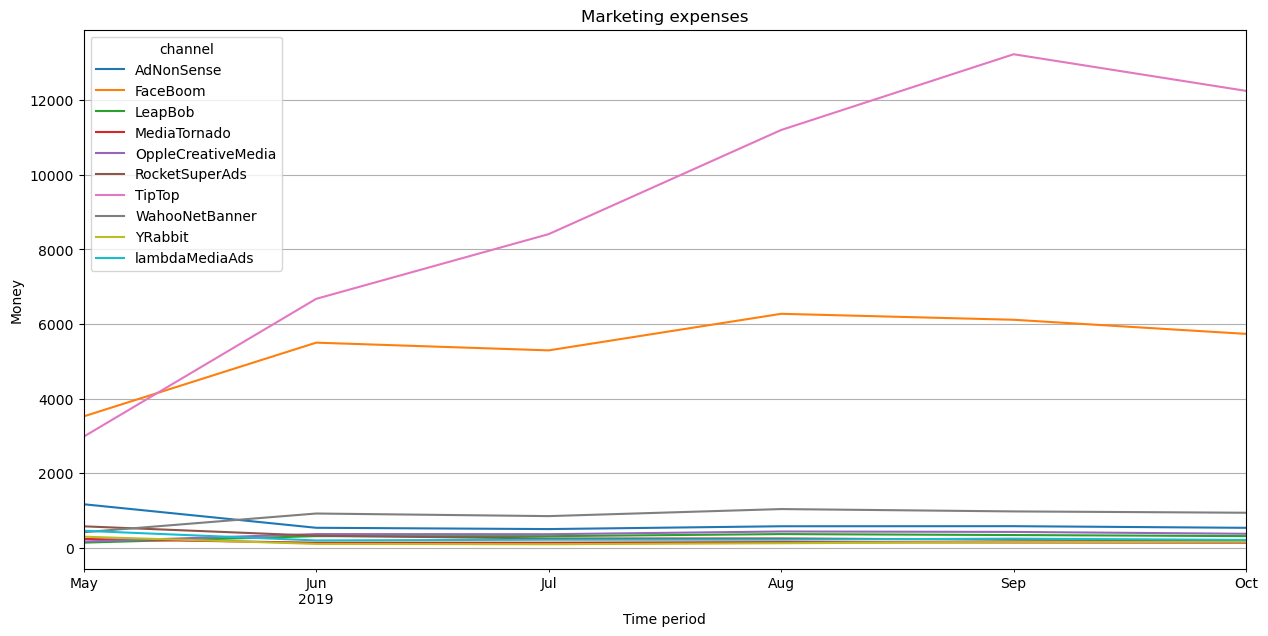

In [110]:
cost.pivot_table(
    index='month',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(
    grid=True, figsize=(15, 7)
)
plt.ylabel('Money')
plt.xlabel('Time period')
plt.title('Marketing expenses')
plt.show() 

Посчитаем расходы по неделям

In [111]:
cost.groupby('week').agg({'costs': 'sum'})

costs
week                
2019-04-25   304.820
2019-05-02  2015.130
2019-05-09  1956.045
2019-05-16  2122.735
2019-05-23  2574.860
2019-05-30  3441.130
2019-06-06  2713.210
2019-06-13  2880.690
2019-06-20  4168.225
2019-06-27  4933.445
2019-07-04  4115.610
2019-07-11  3198.645
2019-07-18  3114.555
2019-07-25  3976.575
2019-08-01  4623.170
2019-08-08  4491.875
2019-08-15  4794.050
2019-08-22  4753.935
2019-08-29  4423.150
2019-09-05  4206.575
2019-09-12  4556.030
2019-09-19  6202.970
2019-09-26  6773.700
2019-10-03  5866.055
2019-10-10  4738.470
2019-10-17  5031.920
2019-10-24  3519.725

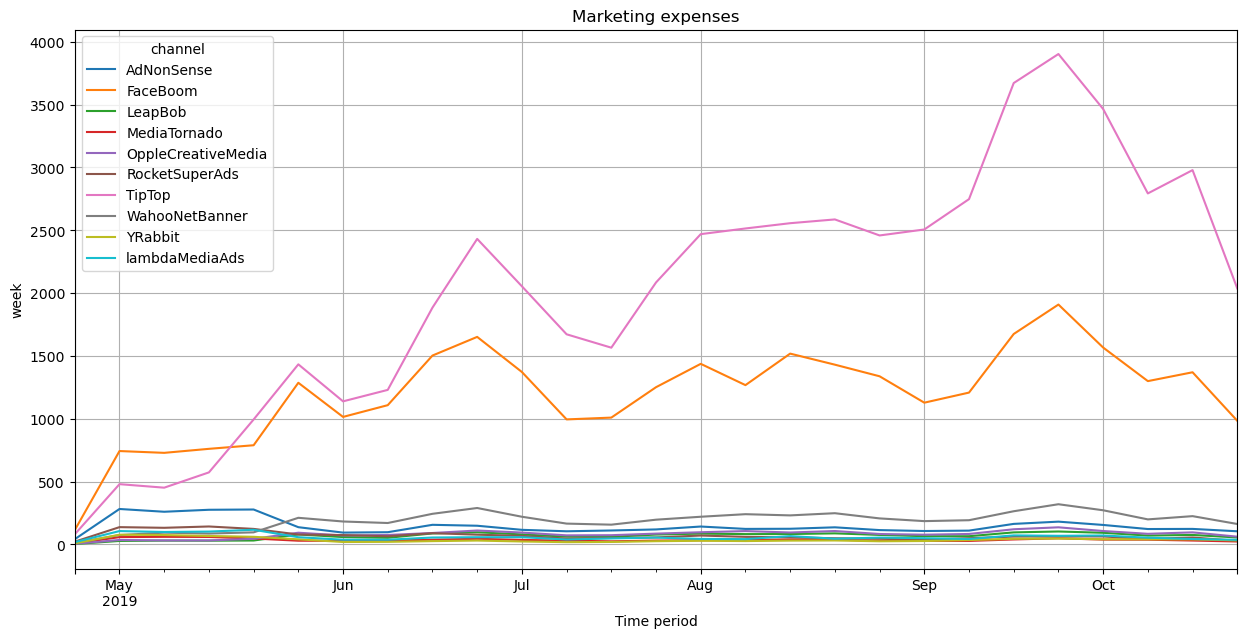

In [112]:
cost.pivot_table(
    index='week',
    columns='channel',
    values='costs',
    aggfunc='sum'
).plot(
    grid=True, figsize=(15, 7)
)
plt.ylabel('week')
plt.xlabel('Time period')
plt.title('Marketing expenses');

**Вывод:** Как видно из графика, большая часть расходов была направлена на два канала, TipTop и FaceBoom. Кроме того, вложения в TipTop постоянно росли, и только в сентябре наметился явный спад. У FaceBoomтоже показатель пошёл вниз, но незначительно. Другие же каналы продвижения почти не используются и находятся на стабильно низком уровне.<br>
Если расматривать расходы по неделям, то можно увидеть явный спад в середине июня у каналов TipTop и FaceBoom, так же можно наблюдать спад в сентябре.  

**Узнаем сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.**

In [113]:
print('Средний САС по всем пользователям платных каналов:', 
      round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2))

Средний САС по всем пользователям платных каналов: 1.13


Расчет среднего САС на одного пользователя каждого канала:

In [114]:
mean_cost_of_channel = pd.DataFrame()
profiles = profiles.query('channel != "organic"')
mean_cost_of_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
mean_cost_of_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

In [115]:
mean_cost_of_channel = (
    profiles
    .query('channel != "organic"')
    .groupby('channel')['acquisition_cost']
    .mean()
    .sort_values(ascending=False))

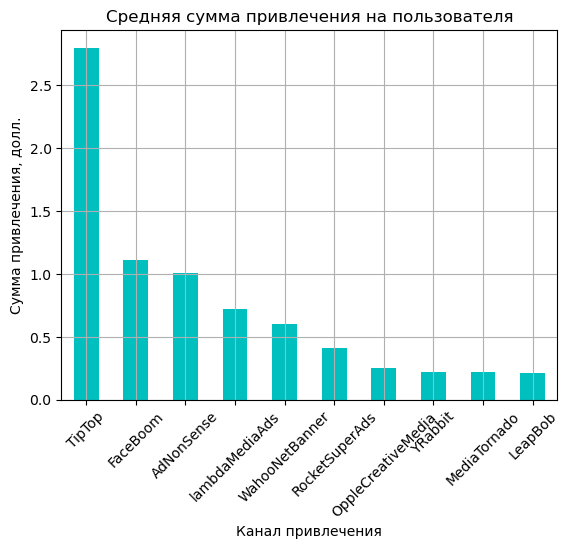

In [116]:
mean_cost_of_channel.plot.bar(
                         grid=True, rot=45, color='c', title='Средняя сумма привлечения на пользователя').set(
                         xlabel="Канал привлечения", ylabel='Сумма привлечения, долл.');

**Вывод по маркетингу:** 
* Общая сумма расходов на рекламу: 105497 дол.;
* Средний САС по всем пользователям платных каналов: 1.13 дол.;
* Юзеры из TipTop и FaceBoom закономерно дороже всех, т.к. в эти каналы были вложены основные средства. Если средняя цена привлечения составляет 0.76, TipTop и FaceBoom 2.79 и 1.11 соответственно.

### Оцените окупаемость рекламы
Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

5.1. Проанализируйте общую окупаемость рекламы. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

5.2. Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

5.3. Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

Опишите обнаруженные проблемы и напишите промежуточные выводы. 5.4. Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Ответьте на такие вопросы:

Окупается ли реклама в целом?
Какие устройства, страны и каналы могут снижать окупаемость рекламы?
Чем могут быть вызваны проблемы окупаемости?
Опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Оценка окупаемости рекламы для привлечения пользователей

**Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

По условию наш момент анализа - 1 ноября 2019 года, а горизонт анализа - две недели

In [117]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

Исключаем бесплатных пользователей

In [118]:
profiles = profiles.query('channel != "organic"')
print('Количество профилей пользователей без "organic":', len(profiles))

Количество профилей пользователей без "organic": 93569


Оценим общую ситуацию c окупаемостью рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

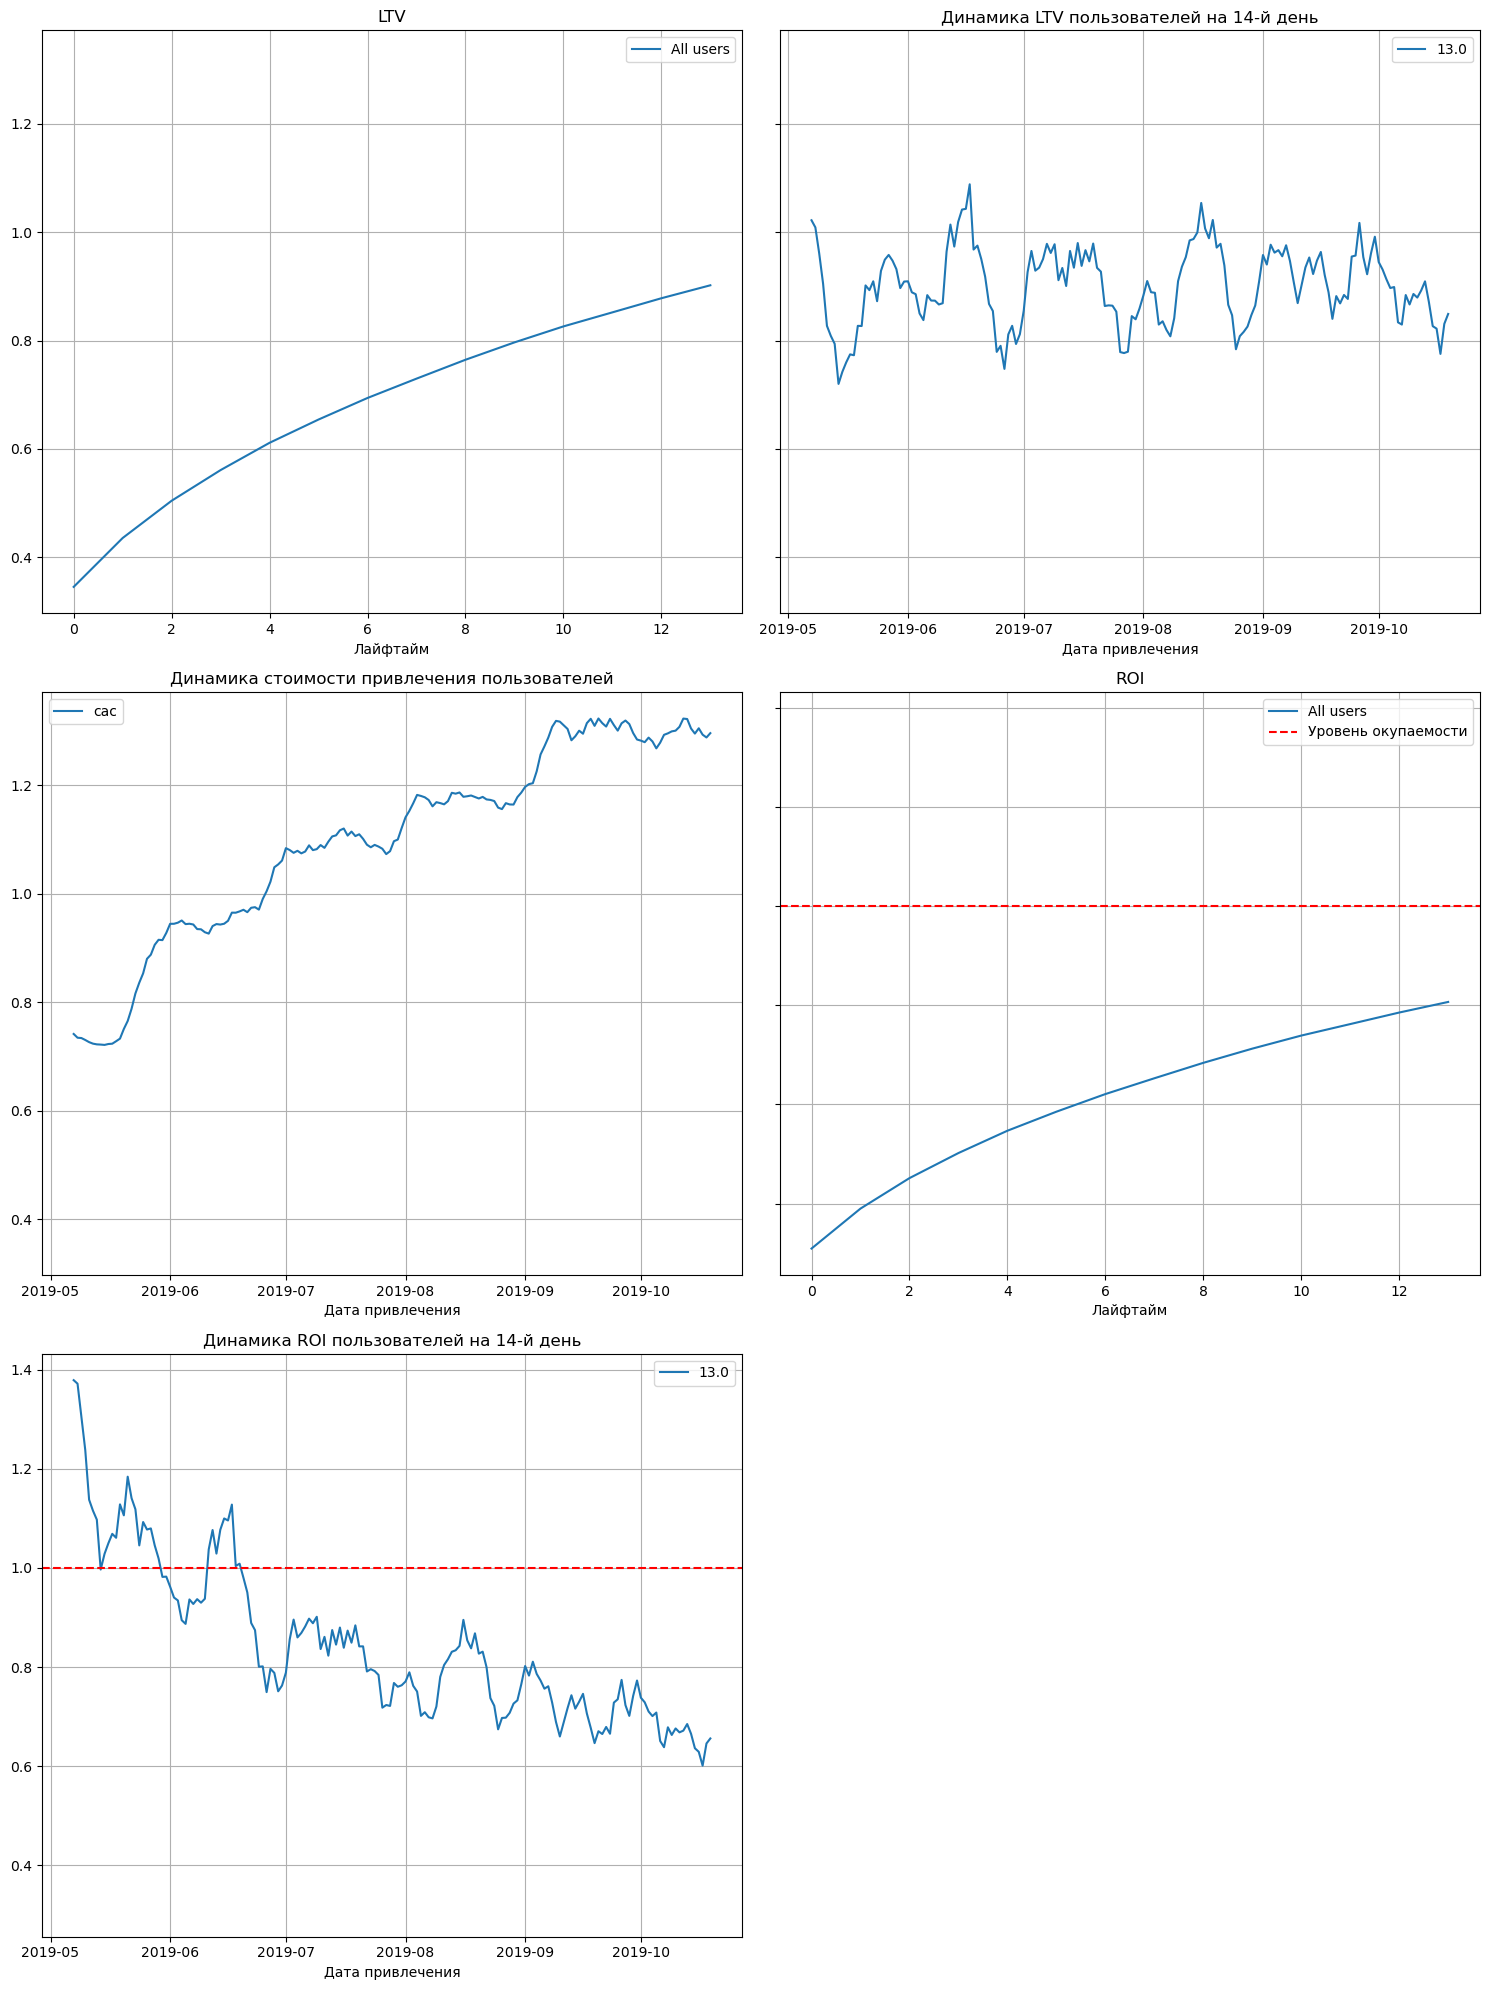

In [119]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:** <br>
Судя по графикам, можно сказать, что рекламная компания убыточная. LTV держится примерно на одном уровне на протяжении всего эксперимента. Динамика ROI показывает уверенный спад, реклама не окупается к концу второй недели и дотягивает только до уровня 80%. Стоимость привлечения (САС) постоянно росла, к августу ROI окончательно опустился ниже предельного уровня (100%).

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

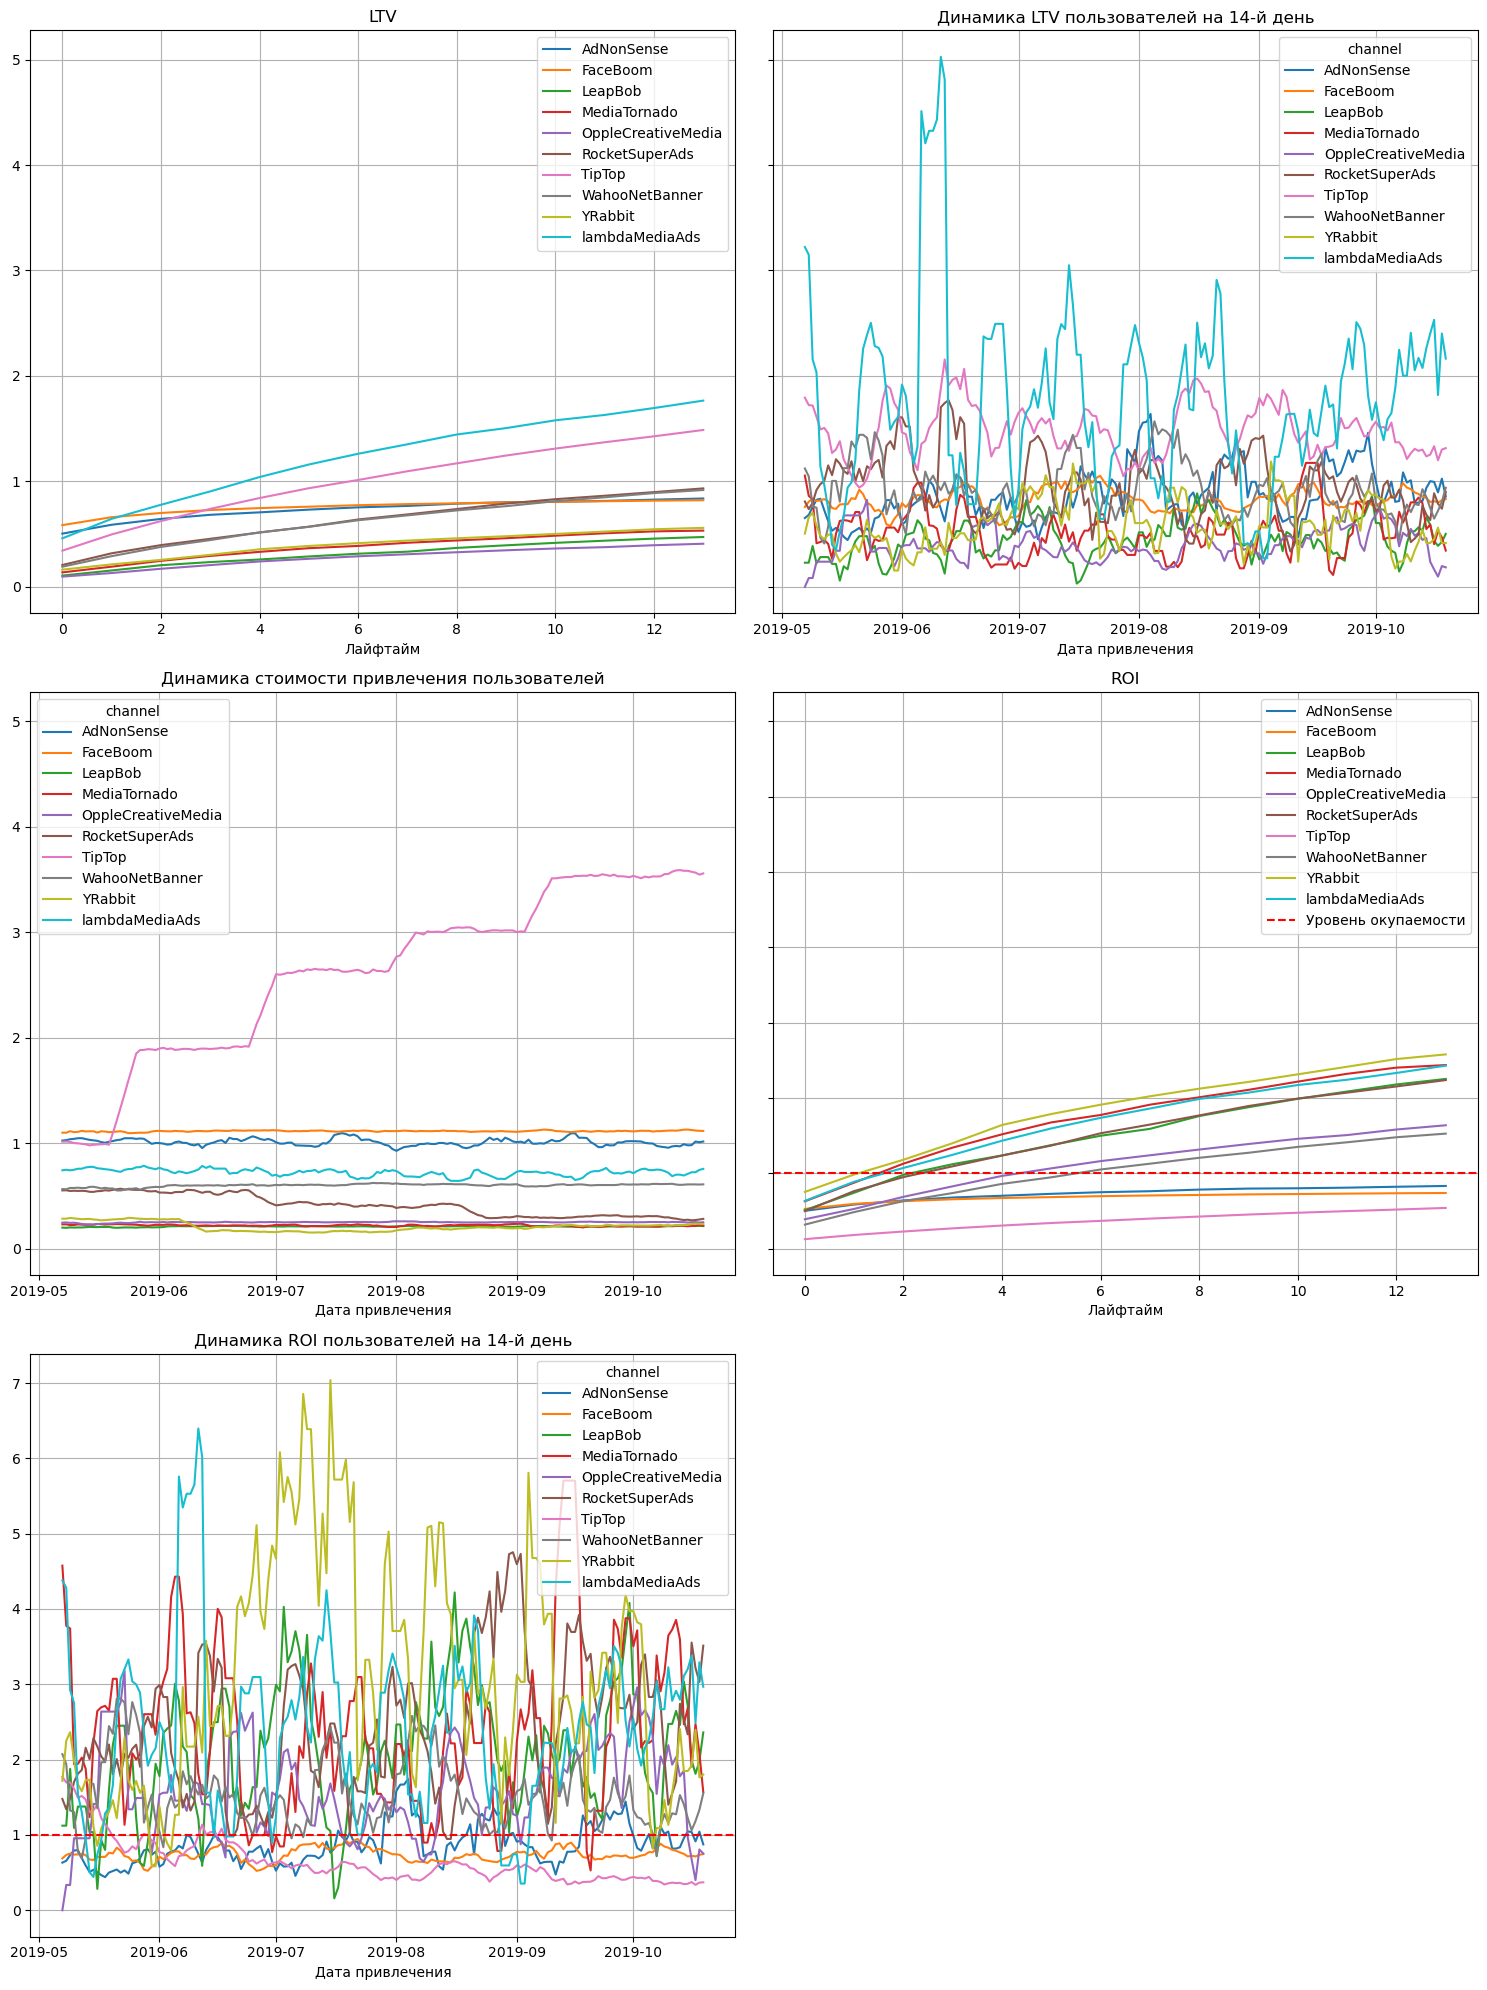

In [120]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions = dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

**Вывод:**<br>
У двух каналов самый высокий LTV, это lambdaMediaAds и TipTop.<br>
Интересно выглядит график CAC канала TipTop, получилась практически идеальная лесенка роста расходов. Расходы на другие каналы были на одном уровне.<br>
Не окупаются три канала привлечения: TipTop, FaceBoom, AdNonSense.

#### Проанализируем окупаемость рекламы с разбивкой по странам

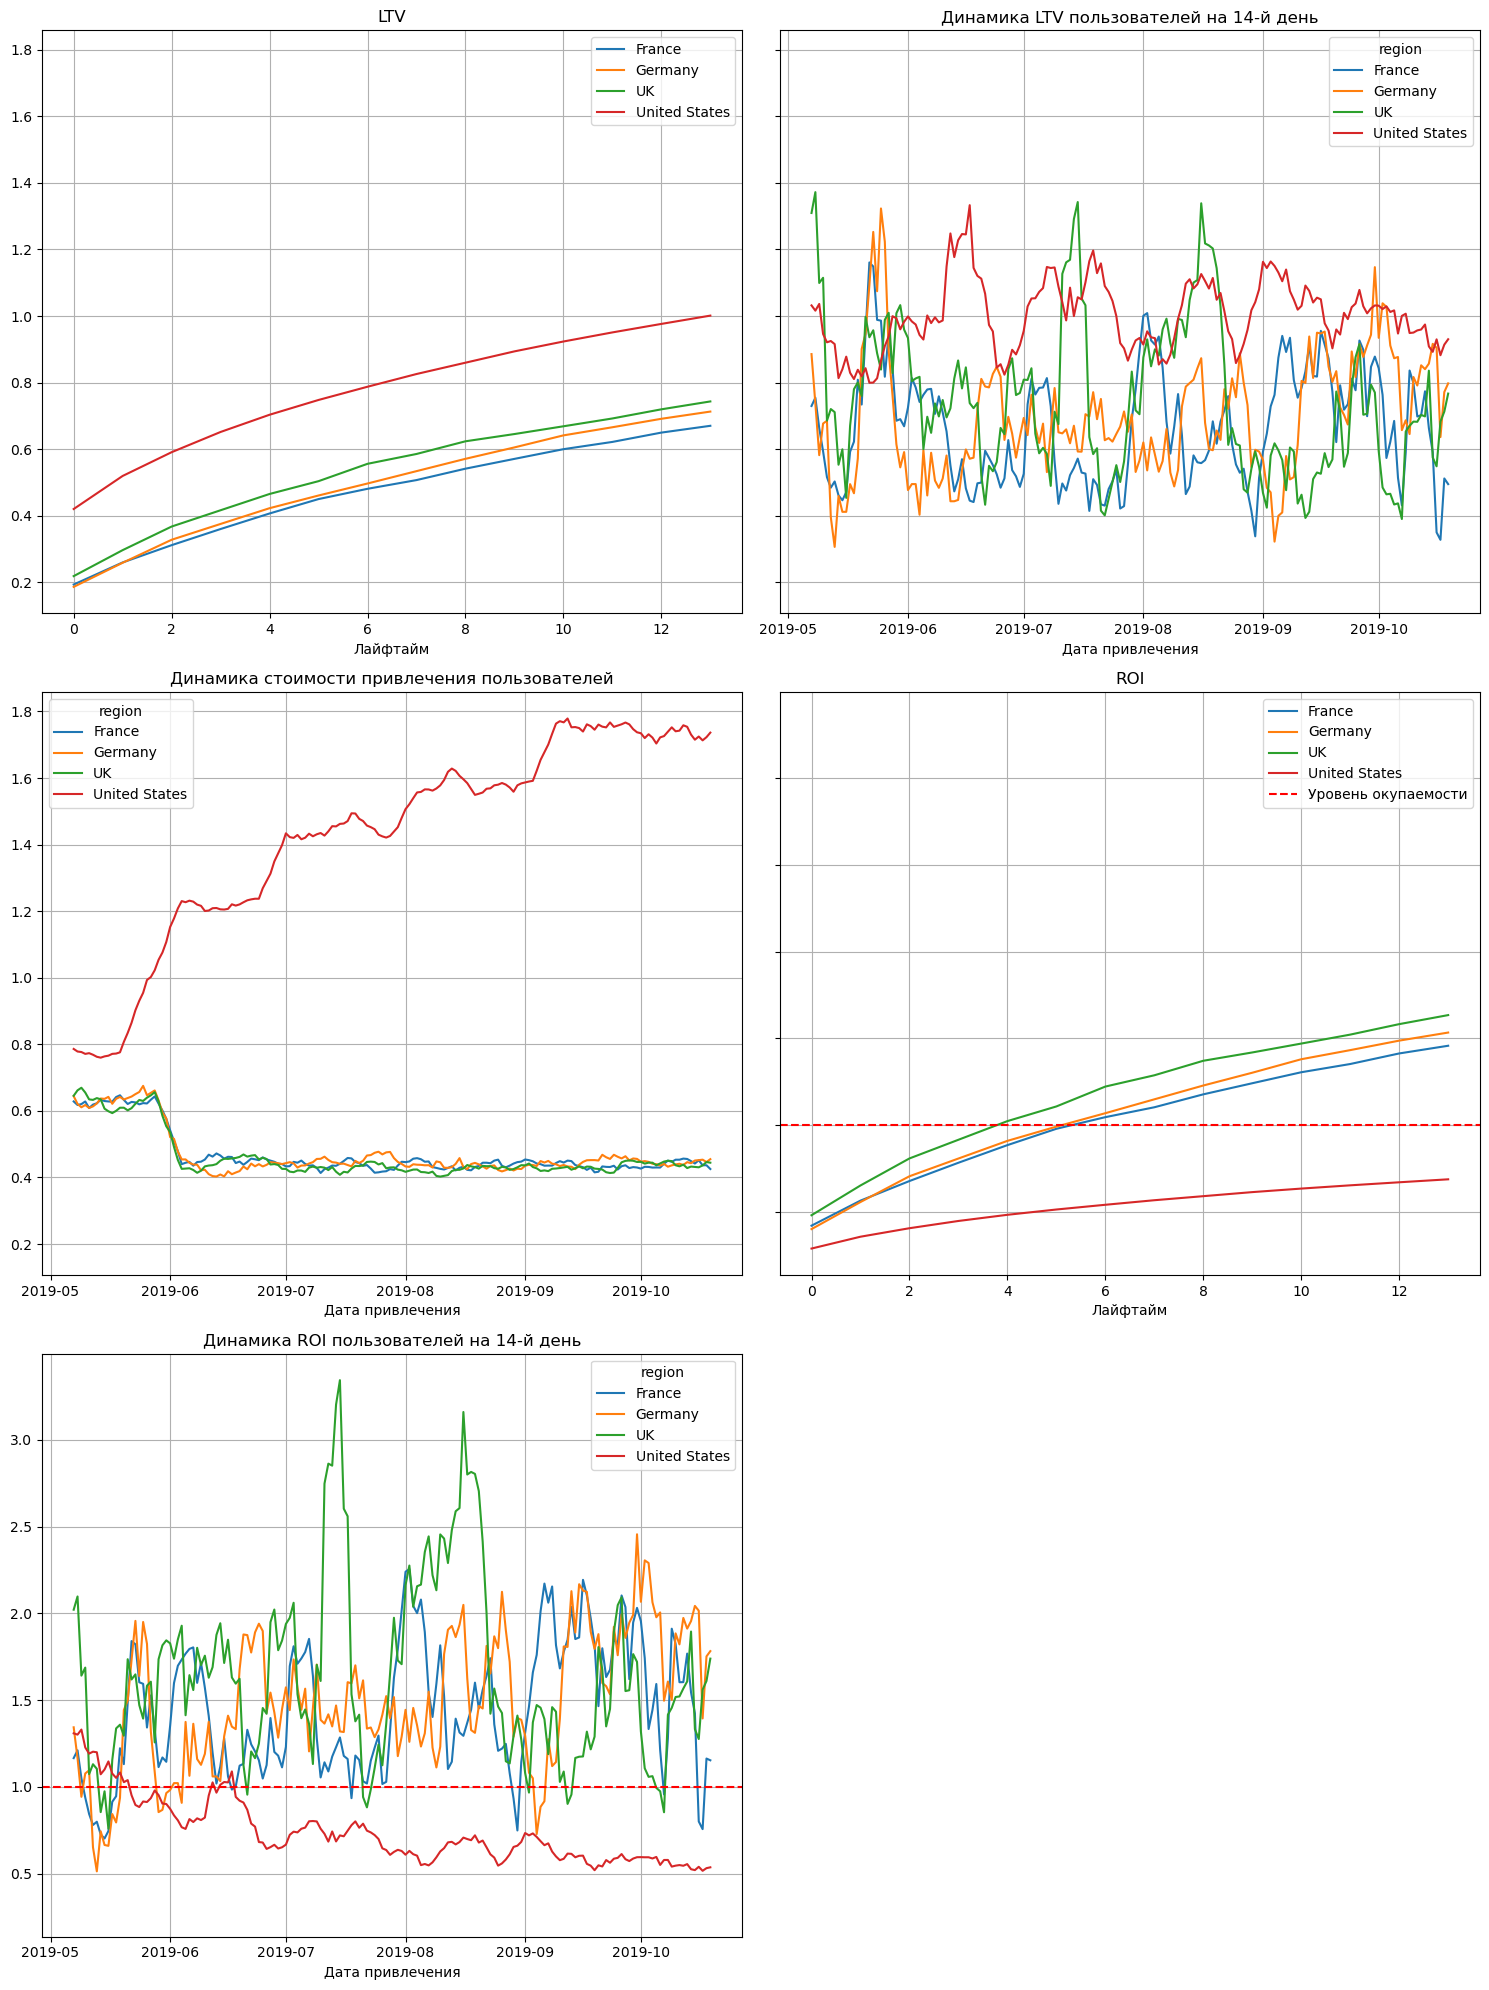

In [121]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, order, observation_date, horizon_days, dimensions = dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days
)

На графиках видно, что пользователи из США обходятся компании дороже всего, график CAC стремится вверх, расходы на другие страны стабильно на одном уровне. Динамика ROI всё время плавно опускается.

#### Изучим и построим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

 **Конверсия по устройствам**

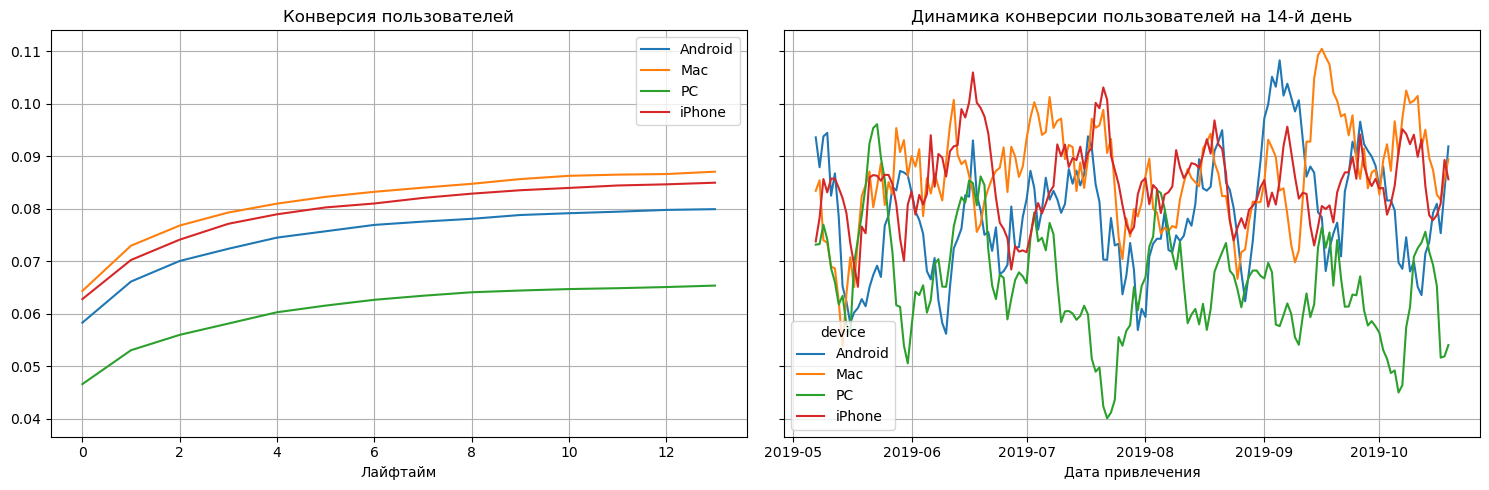

In [122]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, order, observation_date, horizon_days, dimensions = dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:** Пользователи Mac и iPhone конвертируются лучше, их догоняют пользователи Android. Также можно заметить "сезонные" провалы у всех устройств.

**Удержание по устройствам**

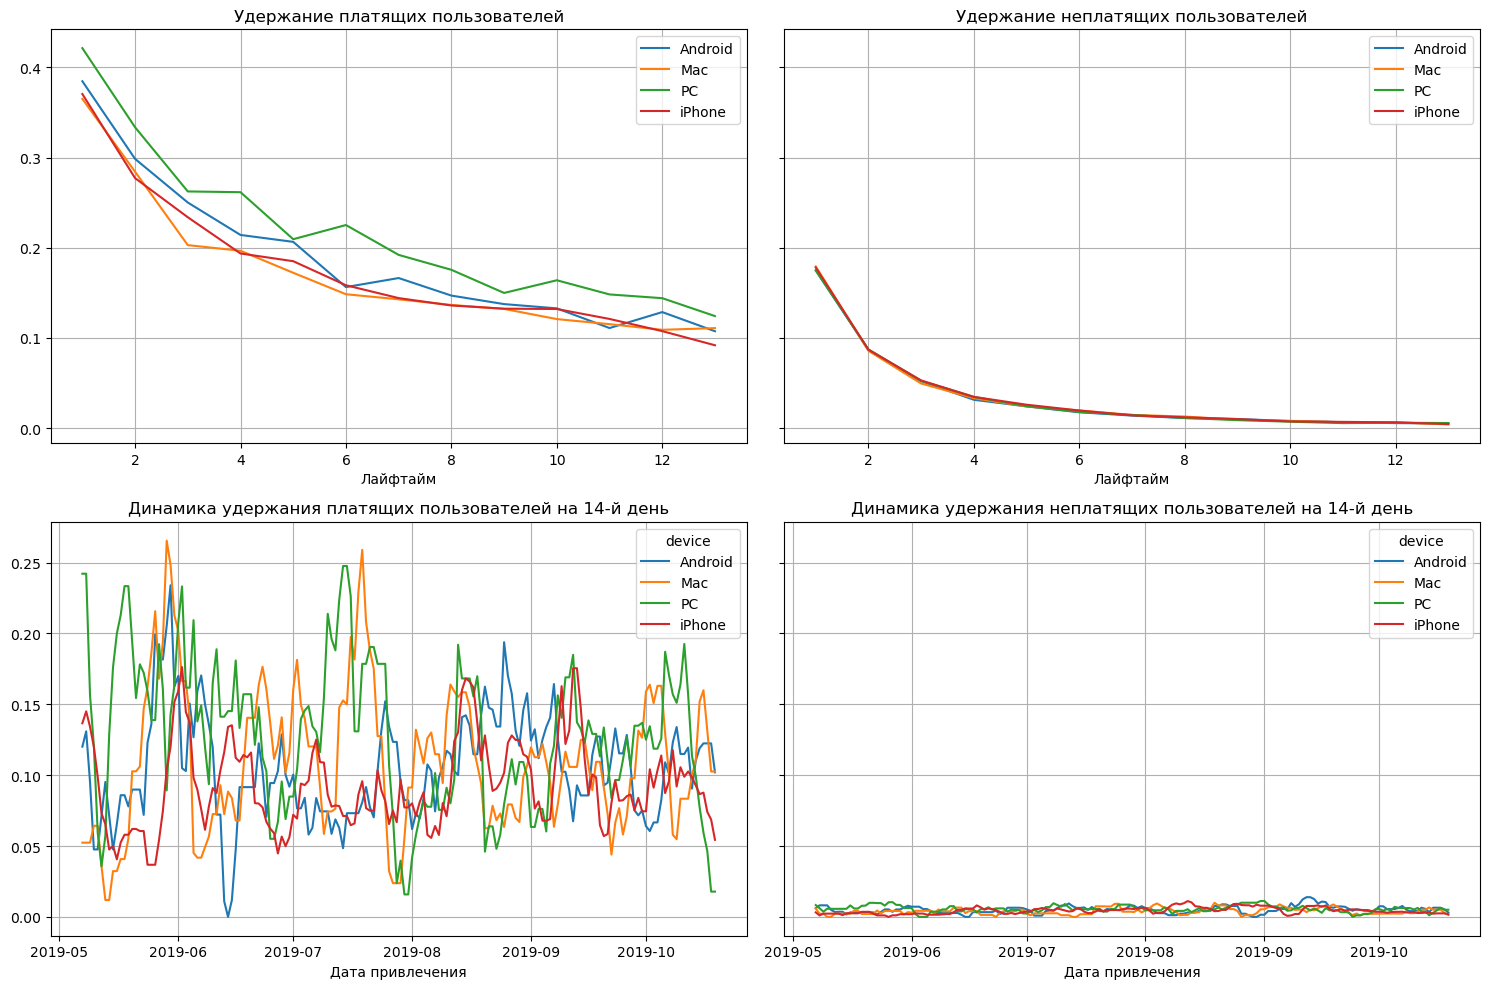

In [123]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:** Динамика удержания неплатящих пользователей примерно одинаковая. Удержание незначительно выше у пользователей PC.

**Конверсия по странам**

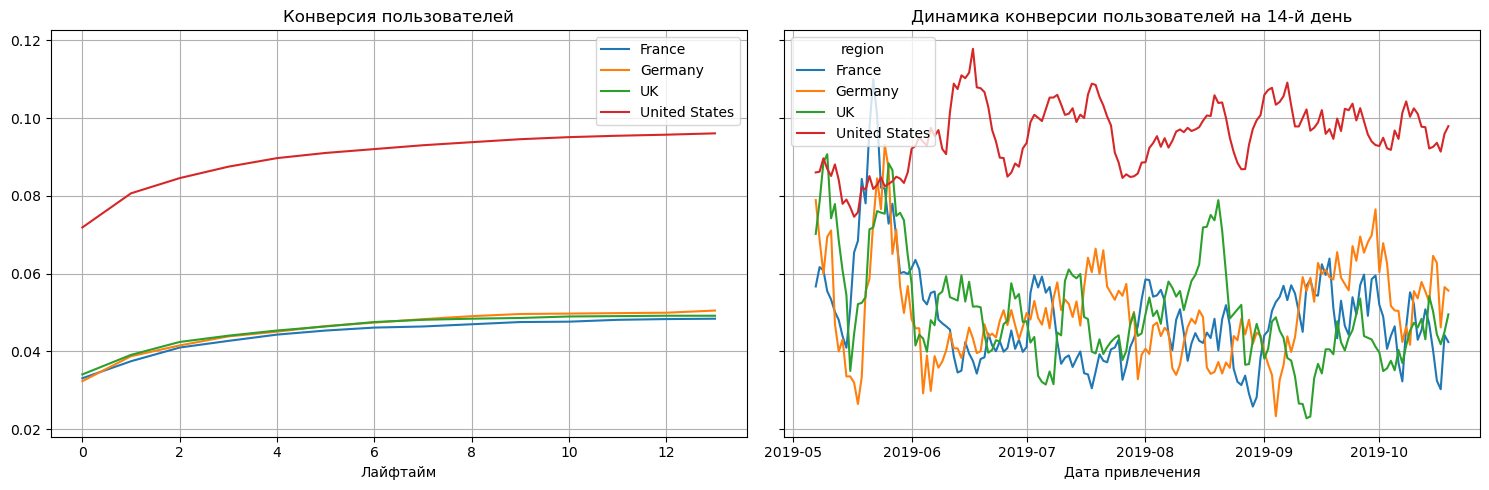

In [124]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, order, observation_date, horizon_days, dimensions = dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:** Пользователи из США конвертируются лучше всех, и довольно значительно. Их конверсия в 2 раза выше , чем у пользователей других регионов, динамика конверсии на 14-й день также стабильна.

**Удержание по странам**

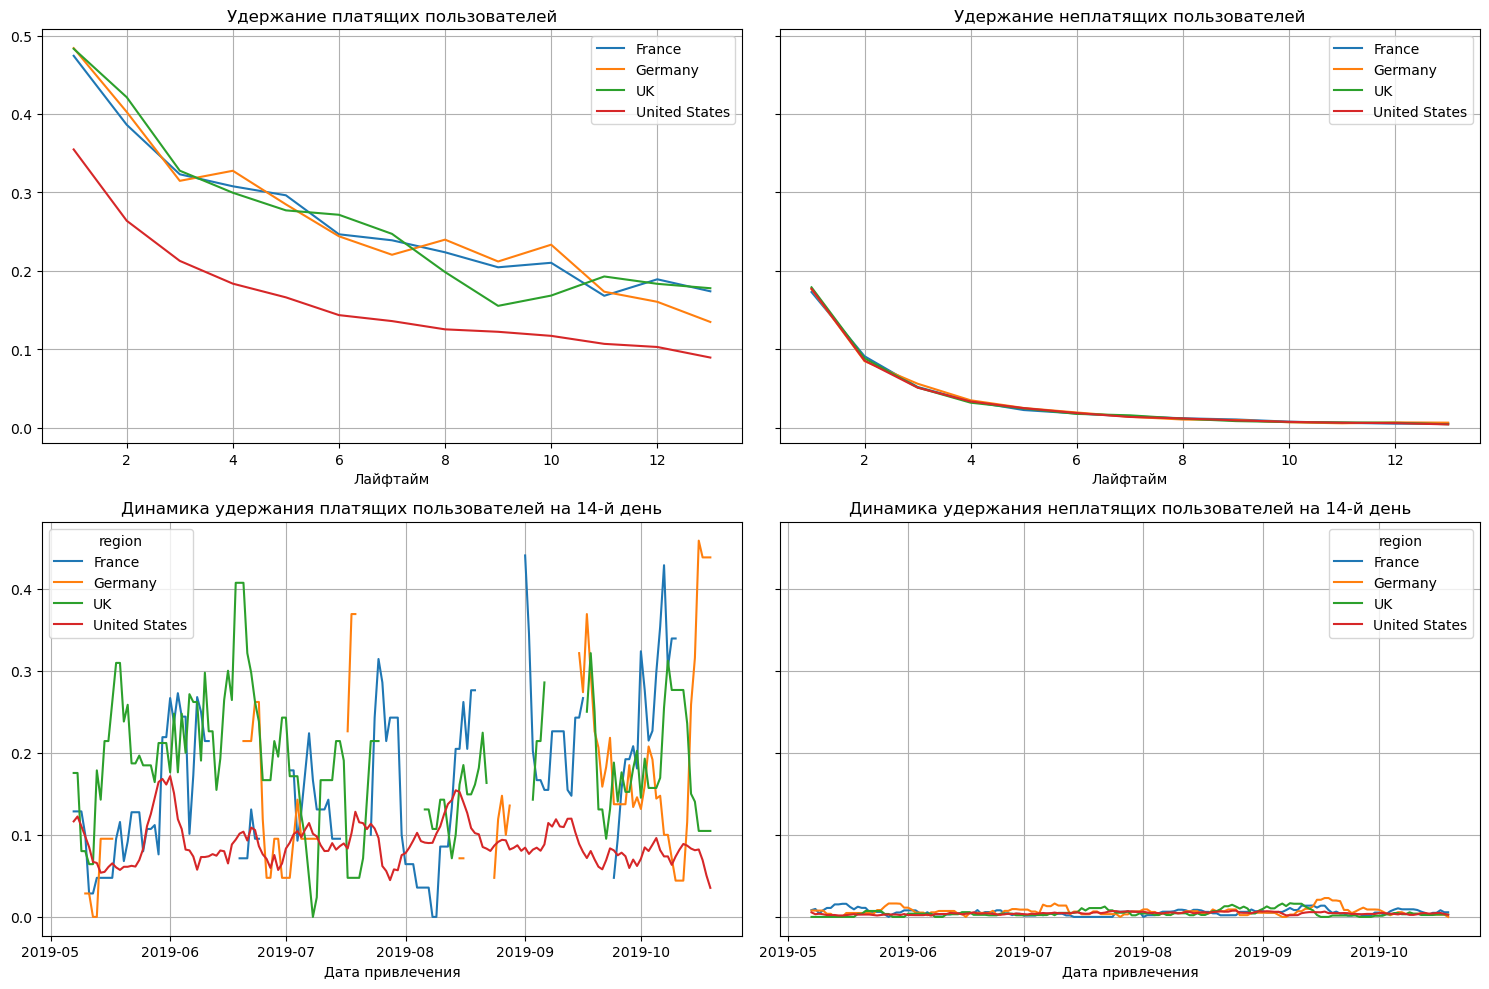

In [125]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:** Коэффициент удержания платящих пользователей из США явно ниже, чем в остальных странах. То есть при высокой конверсии покупатели США быстро уходят.

**Конверсия по рекламным каналам**

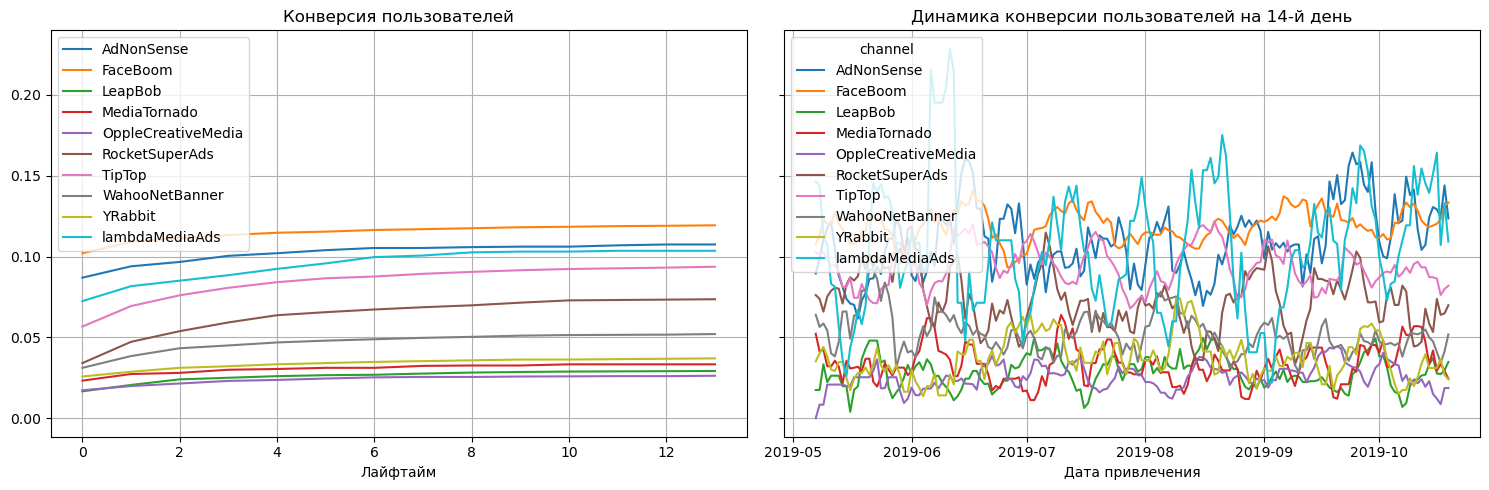

In [126]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, order, observation_date, horizon_days, dimensions = dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:** Самая лучшая конверсия у трёх каналов: FaceBoom, AdNonSense, lambdaMediaAds.

Поскольку проблемы с удержанием только у платящих пользователей из США , ограничим конверсию и удержание с разбивкой по рекламным каналам только профилями США:

In [127]:
profiles_usa = profiles.query('region == "United States"') #выделим профили пользователей США
print(len(profiles_usa)) 

61829


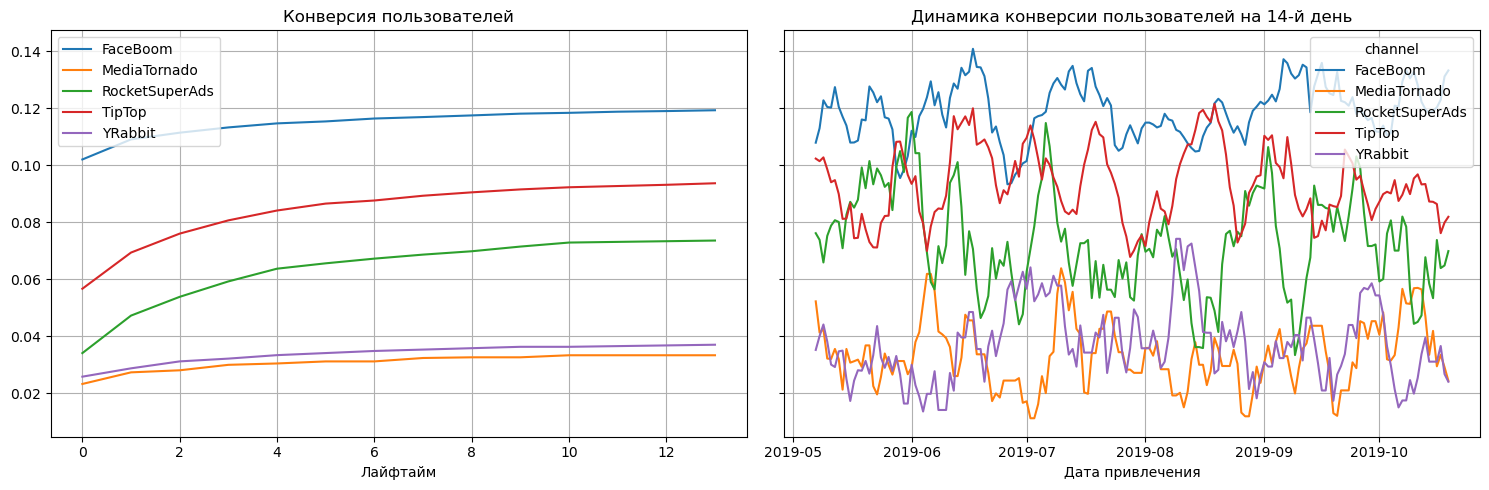

In [128]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, order, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:** Самая высокая конверсия в США - у пользователей, которые пришли из FaceBoom и TipTop.

**Удержание по рекламным каналам**

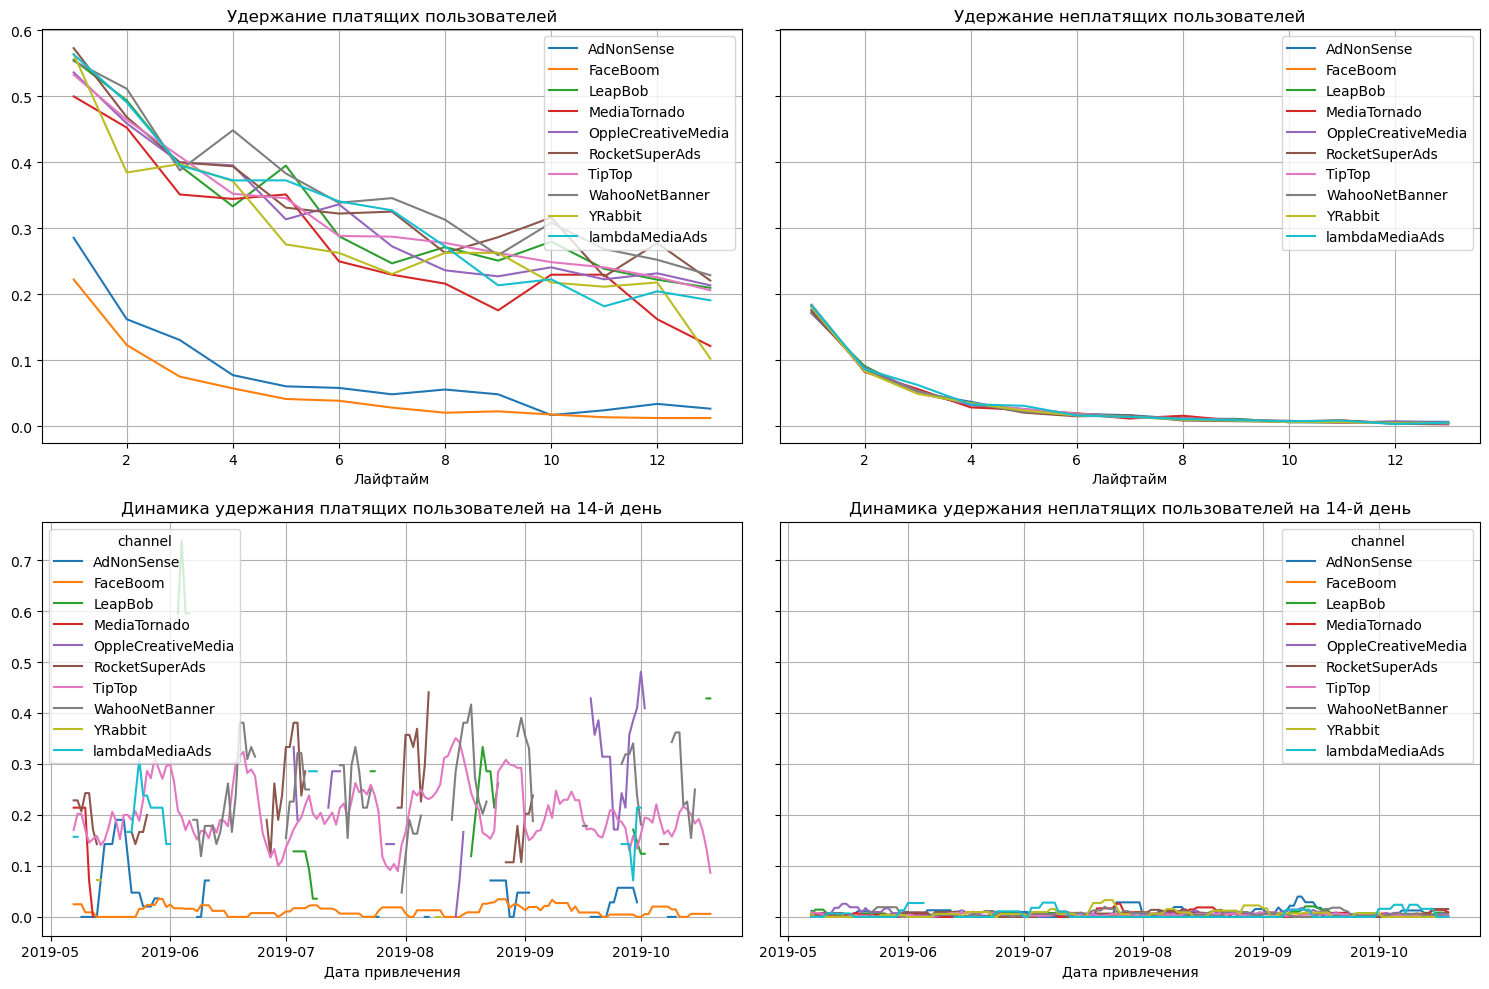

In [129]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visit, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**
Несмотря на хорошую конверсию каналов FaceBoom и AdNonSense, они показывают самое низкое удержание платящих пользователей.

Посмотрим удержание по рекламным каналам отдельно для пользователей США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visit, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:** В США самое низкое удержание платящих пользователей - у пришедших с FaceBoom, тогда как удержание у TipTop в среднем находится на общем уровне с другими каналами привлечения.

**Вывод по оценке окупаемости рекламы**
- Окупаемость рекламы падает к концу второй недели
- Не окупаются три канала привлечения: TipTop, FaceBoom, AdNonSense
- Пользователи из США обходятся компании дороже всего
- Хуже всего удерживаются платящие пользователи устройств IPhone и MAC
- TipTop самый невыгодный канал для привлечения, с которого большинство пользователей из страны США.

#### Причины неэффективности привлечения пользователей

В ходе иследования были выявлены три канала инвестиции в которые не окупились: AdNonSense, FaceBoom, TipTop. Наибольшее число пользователей приложения из США(66.7%), оставшаяся доля приходится почти поравну на Великобританию(11.7%), Францию(11.6) и Германии(10%).<br> 
Также удержание платящих пользователей из США оказалось хуже всех. ROI по странам в динамике показал, что с каждым месяцем привлеченные платящие пользователи из США всё хуже окупались, но динамика стоимости привлечения этих пользователей только наращивалась.<br>  
Больше всего пользователей приложения это владельцы iPhone. Доля платящих пользователей приходится в большей степени на владельцев Mac(6.4%) и iPhone(6.2%).<br> 
В среднем на привлечение одного клиента в целом по проекту расходуется около 76 центов, а если исключить из этой массы долю "organic" и оставить только платные источники- 1.13 долл. на пользователя.<br> 
Самые крупные платные рекламные источники - FaceBoom и TipTop. По доле пользователей, перешедших в категорию платящих, лидируют FaceBoom(12.2%), TipTop(9.6%), и два малоиспользуемых рекламных канала- AdNonSense (11.34%) и lambdaMediaAds (10.47%).<br> 
Общая сумма расходов на рекламу составила 105497 дол. в период с 2019-05-01 по 2019-10-27.

**Возможные причины неэффективности привлечения пользователей:** 
- США приносит убытки по всем показателям воронки, кроме привлечения
- Проблема с устройствами iPhone и Mac при повторной покупки, а именно конверсия с этих устройств хорошая, но удержание - нет с учетом этого показатели САС и ROI не очень хорошие, а возможно, еще связано это с рекламой TipTop, на которую был потрачен не оправданный бюджет
- Рекламная система TipTop оказалась неэффективной. Не стоило много вкладывать в этот канал.
- Конверсия пользователей FaceBoom была самой высокой, но удержание платящих пользователей было самое низкое. Можно ометить, что этот канал для привлечения работал хорошо, но качество платного контента не устраивало пользователей, поэтому не стоит этот канал списывать со счетов.

#### Pекомендации для отдела маркетинга

- Реклама не окупается среди пользователей Mac, iPhone и Android, возможные проблемы начались в июне-июле. Необходимо изучить ошибки в работе приложения на данных устройствах и сравнить их количество с ошибками на устройстве PC. Проверить обновления, которые выходили в июне-июле и корректность их работы на всех устройствах.
- Активнее закупать рекламу в lambdaMediaAds (для европейского рынка), MediaTornado и YRabbit (для американского) - пользователи из этих источников показывают высокий LTV при низкой стоимости привлечения, что делает их самыми окупающимися из всей подборки.
- Оценить экономическую целесообразность высокой цены привлечения пользователей через канал TipTop: при условии, что пользователи, пришедшие из TipTop, хорошего качества (высокий LTV, хорошая конверсия и удержание), расходы не окупаются.
- Уделить больше внимания направлению PC, привлекать больше пользователей этой платформы.
